In [24]:
import sqlite3 as sql
import pandas as pd
import numpy as np

In [25]:
con = sql.connect("nba.sqlite")
cur = con.cursor()

In [26]:
query = "SELECT name FROM sqlite_master WHERE type='table';"
cur.execute(query)
tables = cur.fetchall()

In [27]:
tables

[('game',),
 ('game_summary',),
 ('other_stats',),
 ('officials',),
 ('inactive_players',),
 ('game_info',),
 ('line_score',),
 ('play_by_play',),
 ('player',),
 ('team',),
 ('common_player_info',),
 ('team_details',),
 ('team_history',),
 ('draft_combine_stats',),
 ('draft_history',),
 ('team_info_common',)]

In [28]:
columnDict = {}

for i,table in enumerate(tables):
    query = "SELECT * FROM %s;" % table
    cur.execute(query)
    cols = list(cur.description)
    valuelist = []
    for j, col in enumerate(cols):
        collist = list(col)
        valuelist.append(collist[0])
    columnDict[table] = valuelist

columnDict

{('game',): ['season_id',
  'team_id_home',
  'team_abbreviation_home',
  'team_name_home',
  'game_id',
  'game_date',
  'matchup_home',
  'wl_home',
  'min',
  'fgm_home',
  'fga_home',
  'fg_pct_home',
  'fg3m_home',
  'fg3a_home',
  'fg3_pct_home',
  'ftm_home',
  'fta_home',
  'ft_pct_home',
  'oreb_home',
  'dreb_home',
  'reb_home',
  'ast_home',
  'stl_home',
  'blk_home',
  'tov_home',
  'pf_home',
  'pts_home',
  'plus_minus_home',
  'video_available_home',
  'team_id_away',
  'team_abbreviation_away',
  'team_name_away',
  'matchup_away',
  'wl_away',
  'fgm_away',
  'fga_away',
  'fg_pct_away',
  'fg3m_away',
  'fg3a_away',
  'fg3_pct_away',
  'ftm_away',
  'fta_away',
  'ft_pct_away',
  'oreb_away',
  'dreb_away',
  'reb_away',
  'ast_away',
  'stl_away',
  'blk_away',
  'tov_away',
  'pf_away',
  'pts_away',
  'plus_minus_away',
  'video_available_away',
  'season_type'],
 ('game_summary',): ['game_date_est',
  'game_sequence',
  'game_id',
  'game_status_id',
  'game_sta

This was done so that all of the column names were available to me for my exploration of the data set.

In [29]:
query = "SELECT city, nickname from team_history WHERE year_active_till < 2019 ORDER BY year_founded"
cur.execute(query)
cur.fetchall()

[('Philadelphia', 'Warriors'),
 ('Minneapolis', 'Lakers'),
 ('Rochester', 'Royals'),
 ('Ft. Wayne Zollner', 'Pistons'),
 ('Tri-Cities', 'Blackhawks'),
 ('Syracuse', 'Nationals'),
 ('Milwaukee', 'Hawks'),
 ('St. Louis', 'Hawks'),
 ('Cincinnati', 'Royals'),
 ('San Francisco', 'Warriors'),
 ('San Diego', 'Rockets'),
 ('Seattle', 'SuperSonics'),
 ('Buffalo', 'Braves'),
 ('Kansas City-Omaha', 'Kings'),
 ('New Orleans', 'Jazz'),
 ('Kansas City', 'Kings'),
 ('New York', 'Nets'),
 ('New Jersey', 'Nets'),
 ('San Diego', 'Clippers'),
 ('Vancouver', 'Grizzlies'),
 ('New Orleans', 'Hornets'),
 ('New Orleans/Oklahoma City', 'Hornets'),
 ('New Orleans', 'Hornets')]

# Overall Plan

With that initial query and seeing all the possible columns in each possible table now some analysis may begin. The first order of business will be to take a look at some of the trends in the NBA in terms of 3 point shooting, pace, and other statistics. 

Second, I also want to take a look at some of the top playes (ranked by salary) and combine that with some of their draft history and combine stats. Specifically I will look at when they were drafted, and height, weight, position both at the combine and currently. This is to see if they physically changed over time or changed position. 

# Seasonal Data

One of the larger trend is three point shooting which has become a more signficant part of the game in recent years. There are also talks about pace and whether the game is getting faster and faster and thus more points are being scored. So, I want to look at the most important stats like points, and rebounds as well as three point shooting and free throw attempts. 

In [66]:
query = """SELECT season_id as 'Year', 
        AVG(pts_home + pts_away) as 'Average Total Points', 
        AVG(reb_home + reb_away) as 'Average Total Rebounds', 
        AVG(ast_home + ast_away) as 'Average Total Assists', 
        AVG(stl_home + stl_away) as 'Average Total Steals', 
        AVG(blk_home + blk_away) as 'Average Total Blocks', 
        AVG(fta_home + fta_away) as 'Average Total FTA', 
        AVG(fg3a_home + fg3a_away) as 'Average Total 3PA' 
        from game group by SUBSTRING(season_id,2,4)"""
cur.execute(query)
cur.fetchall()

[('21946',
  135.84571428571428,
  None,
  None,
  None,
  None,
  48.917647058823526,
  None),
 ('21947', 145.2093023255814, None, 10.8, None, None, 54.37864077669903, 0.0),
 ('21948', 159.8842105263158, None, 36.0, None, None, 62.76123595505618, None),
 ('21949', 160.12816188870153, None, None, None, None, 66.148623853211, None),
 ('21950',
  168.23821989528795,
  102.77777777777777,
  47.529411764705884,
  None,
  None,
  66.52054794520548,
  None),
 ('21951',
  167.91036414565826,
  110.8,
  50.125,
  None,
  None,
  58.40909090909091,
  None),
 ('21952',
  164.66755319148936,
  117.0,
  45.0,
  None,
  None,
  71.35897435897436,
  None),
 ('21953',
  159.56034482758622,
  21.636363636363637,
  8.727272727272727,
  None,
  None,
  66.41304347826087,
  None),
 ('21954',
  186.7556270096463,
  73.33333333333333,
  23.0,
  None,
  None,
  74.71875,
  None),
 ('21955',
  198.07987220447285,
  128.0,
  39.0,
  None,
  None,
  77.05263157894737,
  None),
 ('21956',
  200.50809061488673,


In [67]:
SeasonDF = pd.read_sql_query(query, con)
SeasonDF['Year'] = SeasonDF['Year'].str[1:]


In [68]:
SeasonDF.head()


,Year,Average Total Points,Average Total Rebounds,Average Total Assists,Average Total Steals,Average Total Blocks,Average Total FTA,Average Total 3PA
0,1946,135.845714,NaN,NaN,NaN,NaN,48.917647,NaN
1,1947,145.209302,NaN,10.800000,NaN,NaN,54.378641,0.0
2,1948,159.884211,NaN,36.000000,NaN,NaN,62.761236,NaN
3,1949,160.128162,NaN,NaN,NaN,NaN,66.148624,NaN
4,1950,168.238220,102.777778,47.529412,NaN,NaN,66.520548,NaN


<Axes: title={'center': 'Average Total Points by year in the NBA'}, xlabel='Year', ylabel='Average Total Points'>

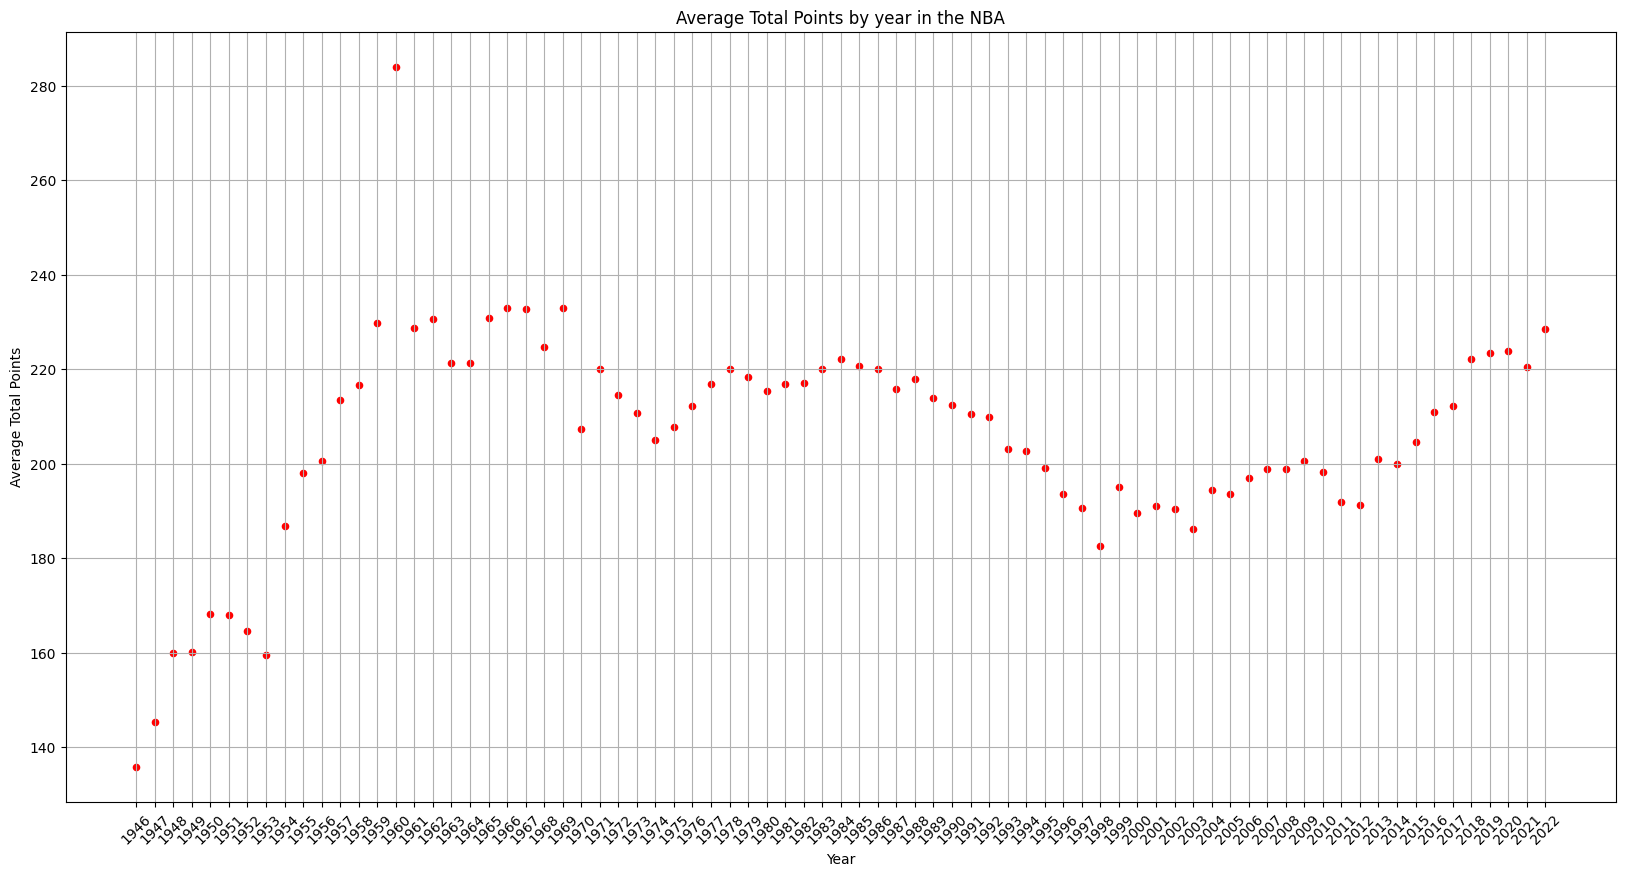

In [59]:
SeasonDF.plot.scatter(x='Year', y='Average Total Points', c='red', figsize = (20,10), rot = 45,title="Average Total Points by year in the NBA", grid=True)



<Axes: title={'center': 'Average Total Assists by year in the NBA'}, xlabel='Year', ylabel='Average Total Assists'>

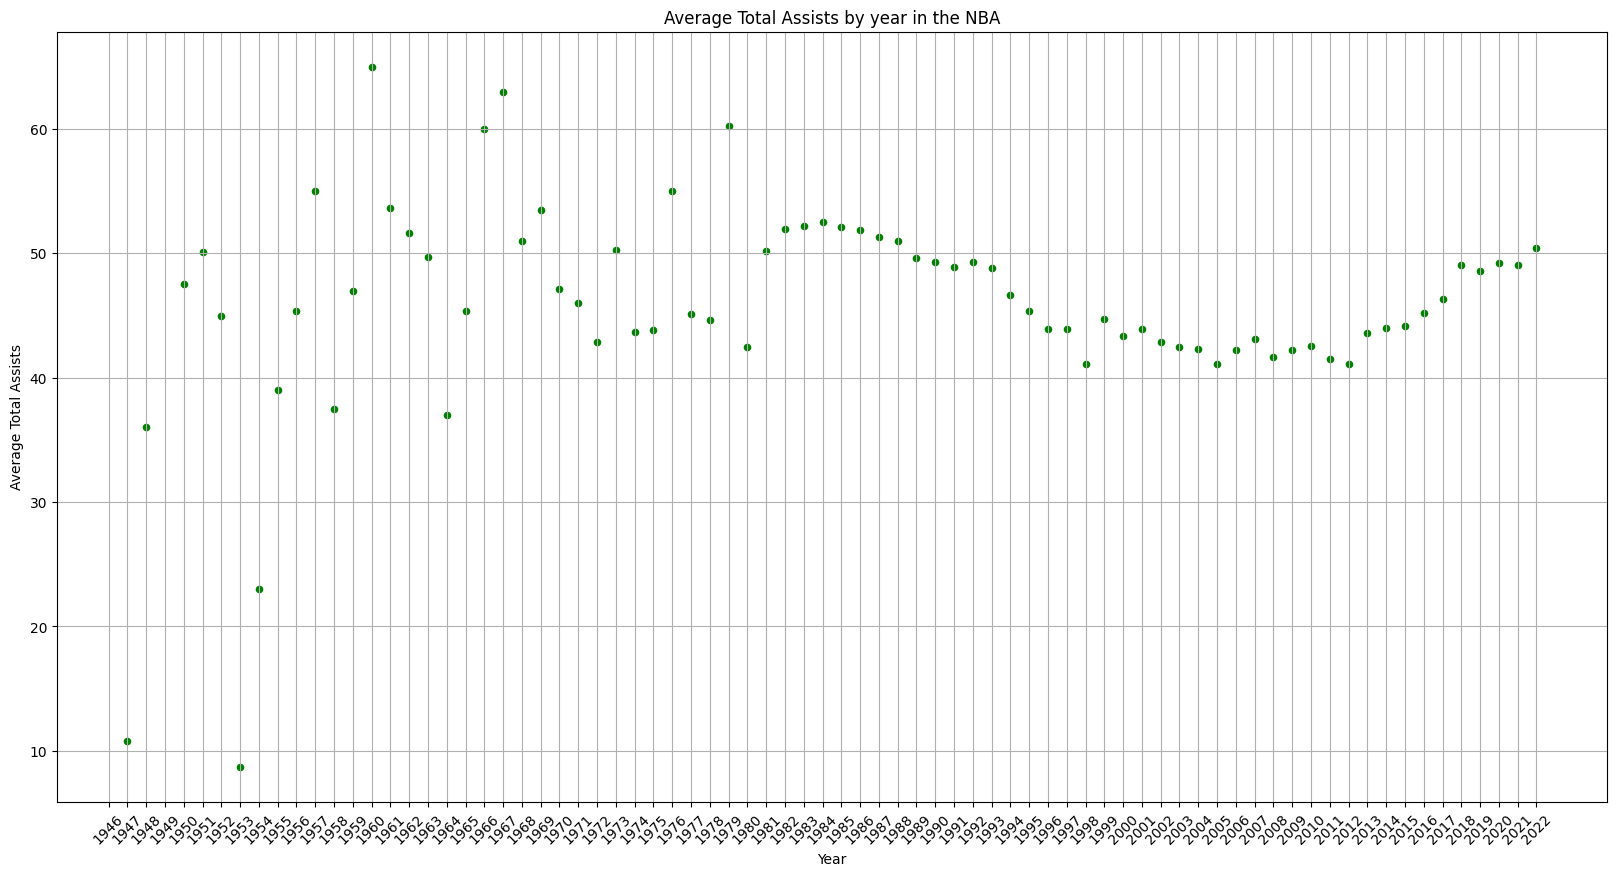

In [65]:
SeasonDF.plot.scatter(x='Year', y='Average Total Assists', c='green', figsize = (20,10), rot = 45, title="Average Total Assists by year in the NBA", grid=True)

<Axes: title={'center': 'Average Total Rebounds by year in the NBA'}, xlabel='Year', ylabel='Average Total Rebounds'>

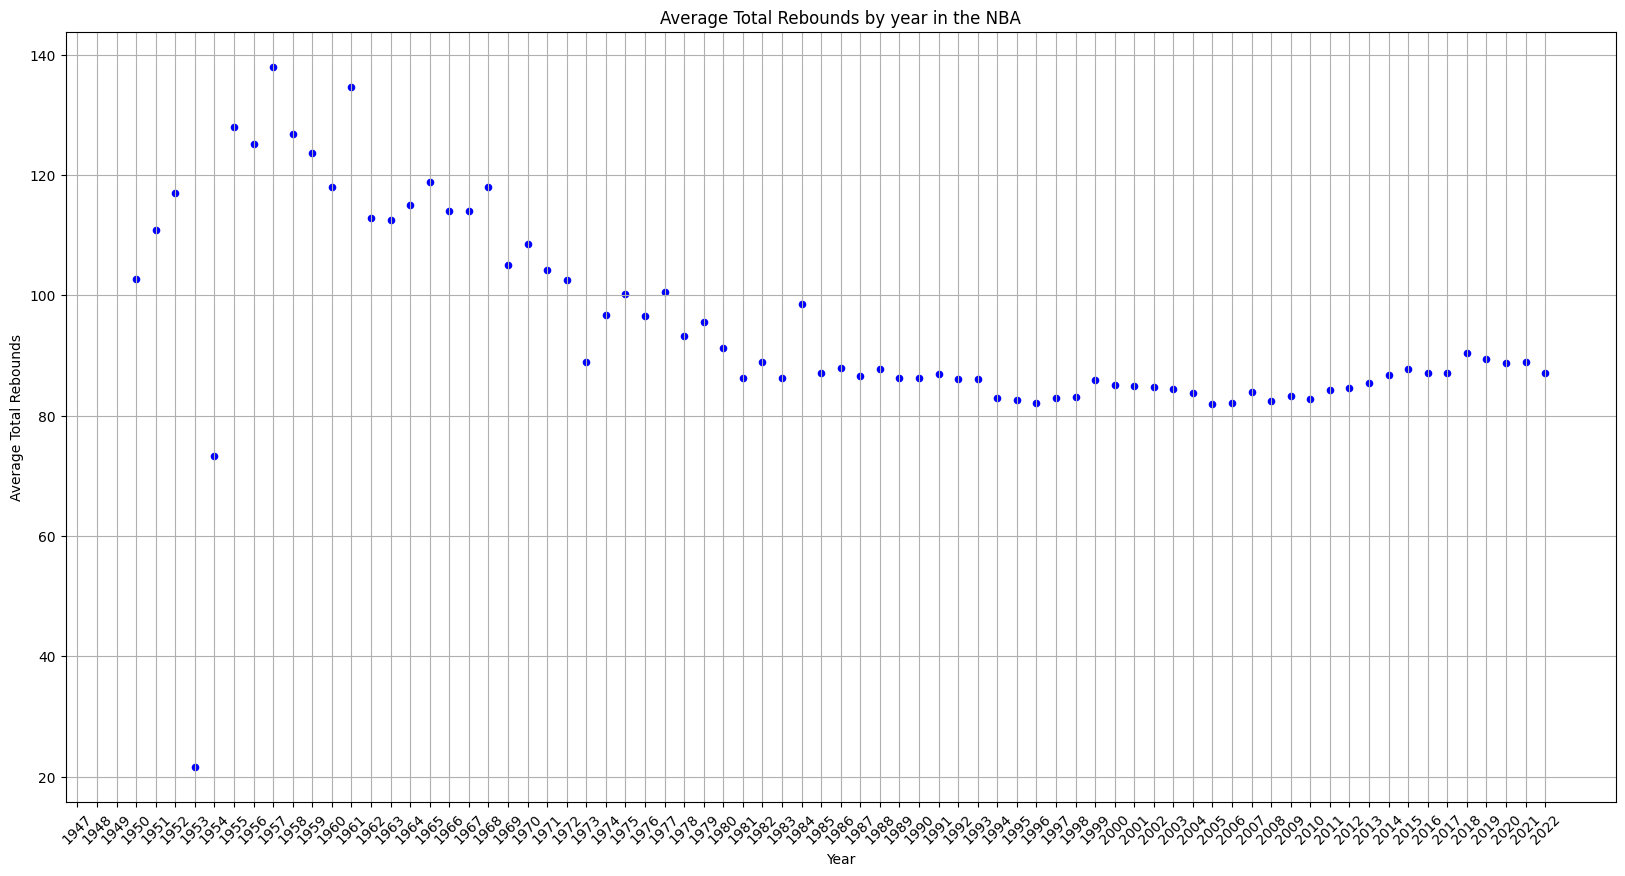

In [64]:
SeasonDF.plot.scatter(x='Year', y='Average Total Rebounds', c='blue', figsize = (20,10), rot = 45, title="Average Total Rebounds by year in the NBA", grid=True)

<Axes: title={'center': 'Average Total Steals by year in the NBA'}, xlabel='Year', ylabel='Average Total Steals'>

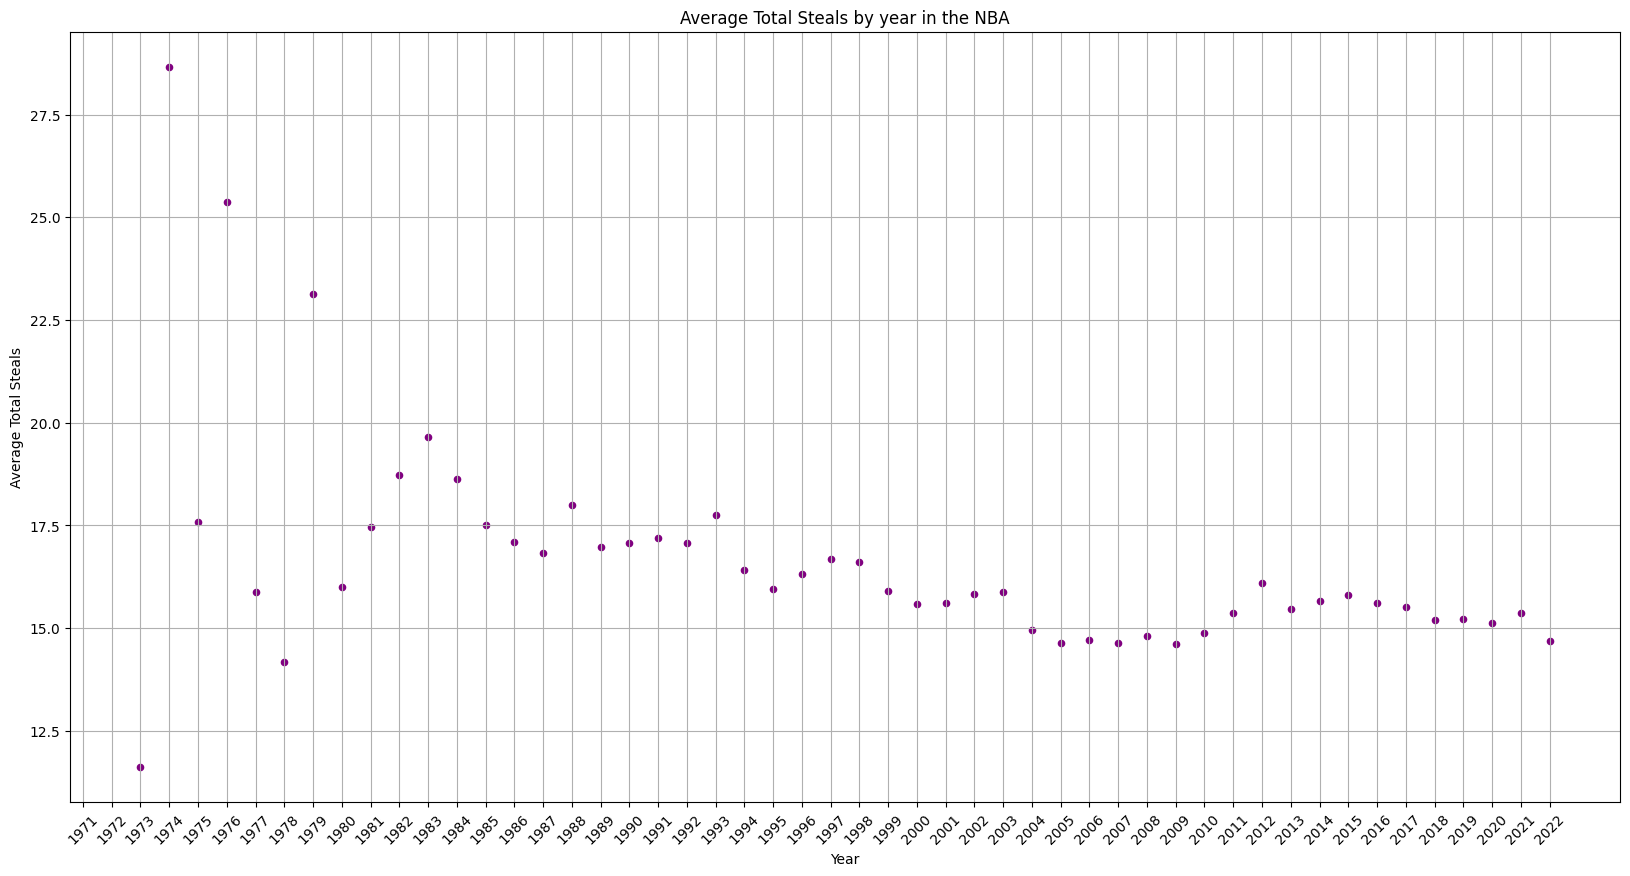

In [62]:
SeasonDF.plot.scatter(x='Year', y='Average Total Steals', c='purple', figsize = (20,10), rot = 45, title="Average Total Steals by year in the NBA", grid=True)

<Axes: title={'center': 'Average Total Blocks by year in the NBA'}, xlabel='Year', ylabel='Average Total Blocks'>

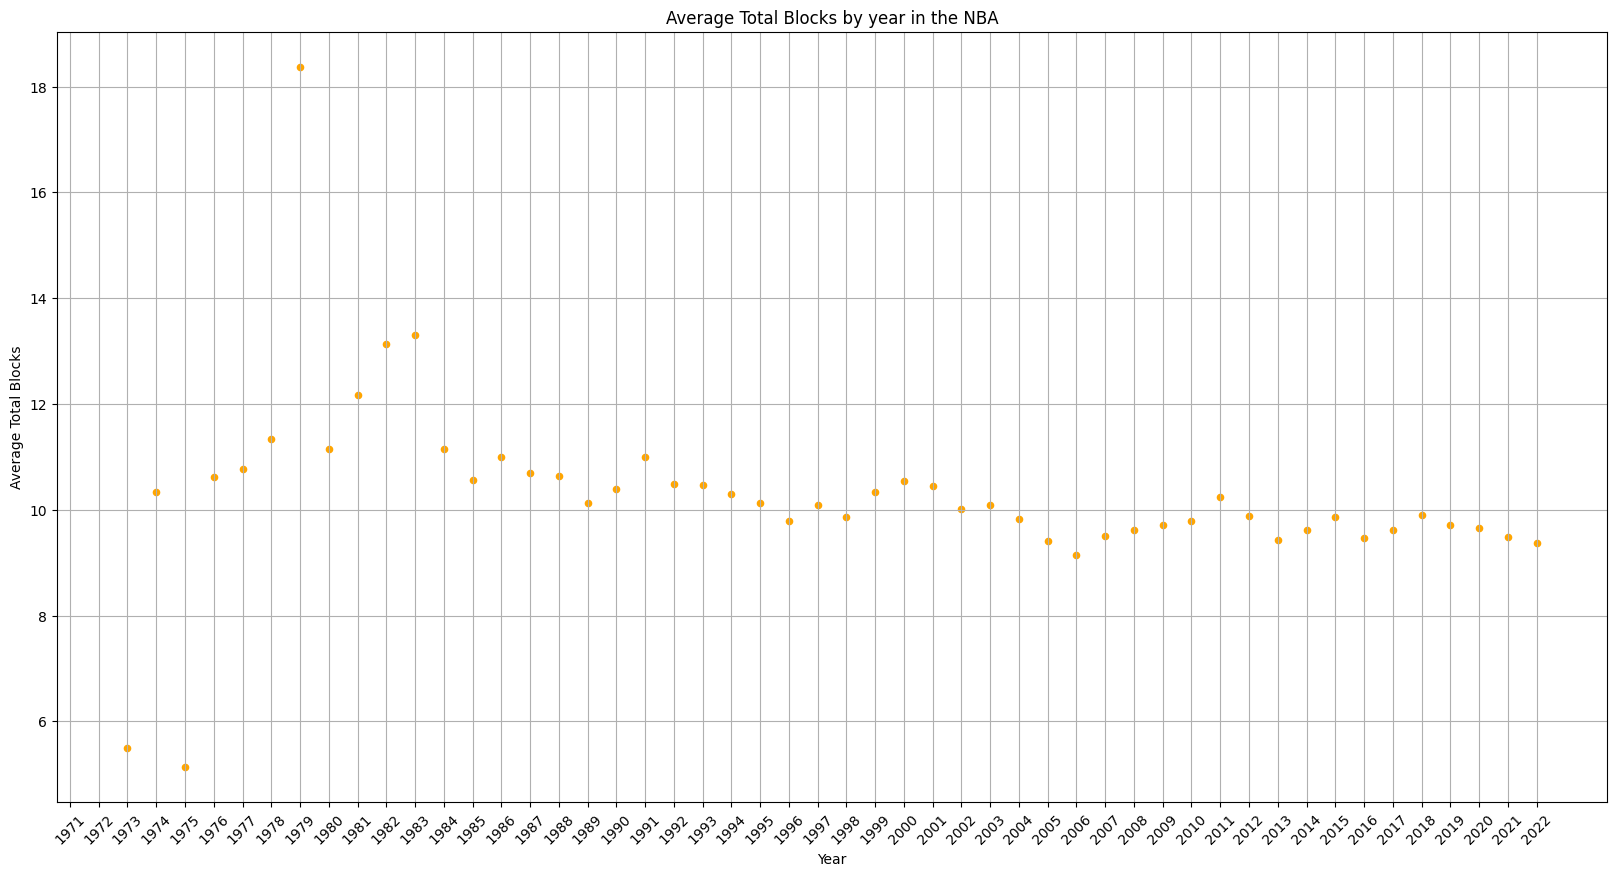

In [63]:
SeasonDF.plot.scatter(x='Year', y='Average Total Blocks', c='orange', figsize = (20,10), rot = 45, title="Average Total Blocks by year in the NBA", grid=True)

<Axes: title={'center': 'Average Total Free Throw Attempts by year in the NBA'}, xlabel='Year', ylabel='Average Total FTA'>

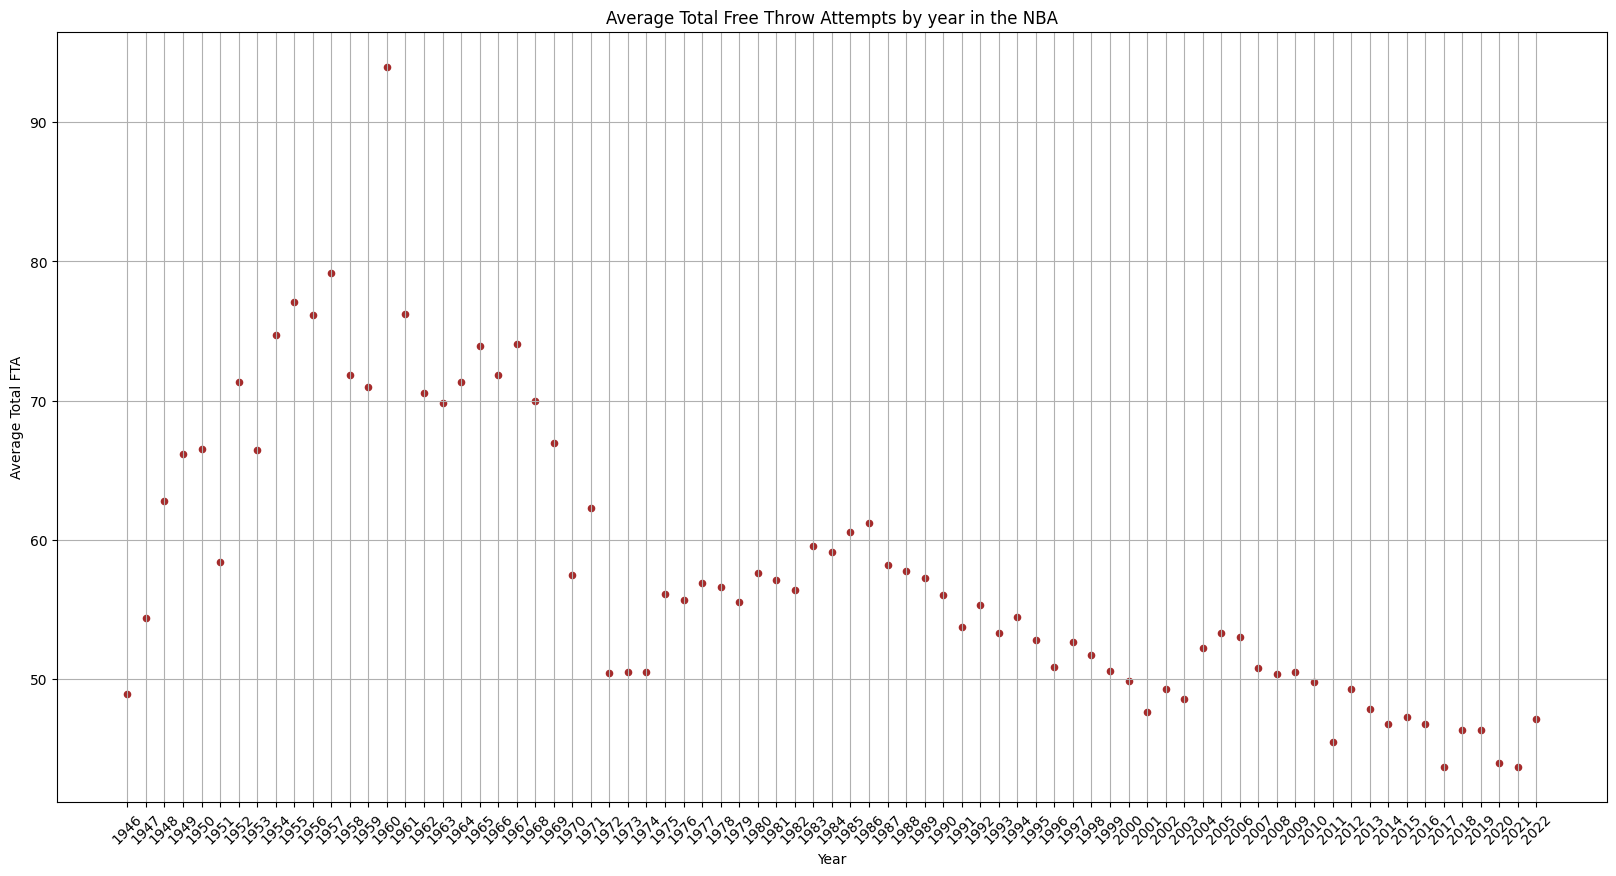

In [70]:
SeasonDF.plot.scatter(x='Year', y='Average Total FTA', c='brown', figsize = (20,10), rot = 45, title="Average Total Free Throw Attempts by year in the NBA", grid=True)

<Axes: title={'center': 'Average Total Three Point Attempts by year in the NBA'}, xlabel='Year', ylabel='Average Total 3PA'>

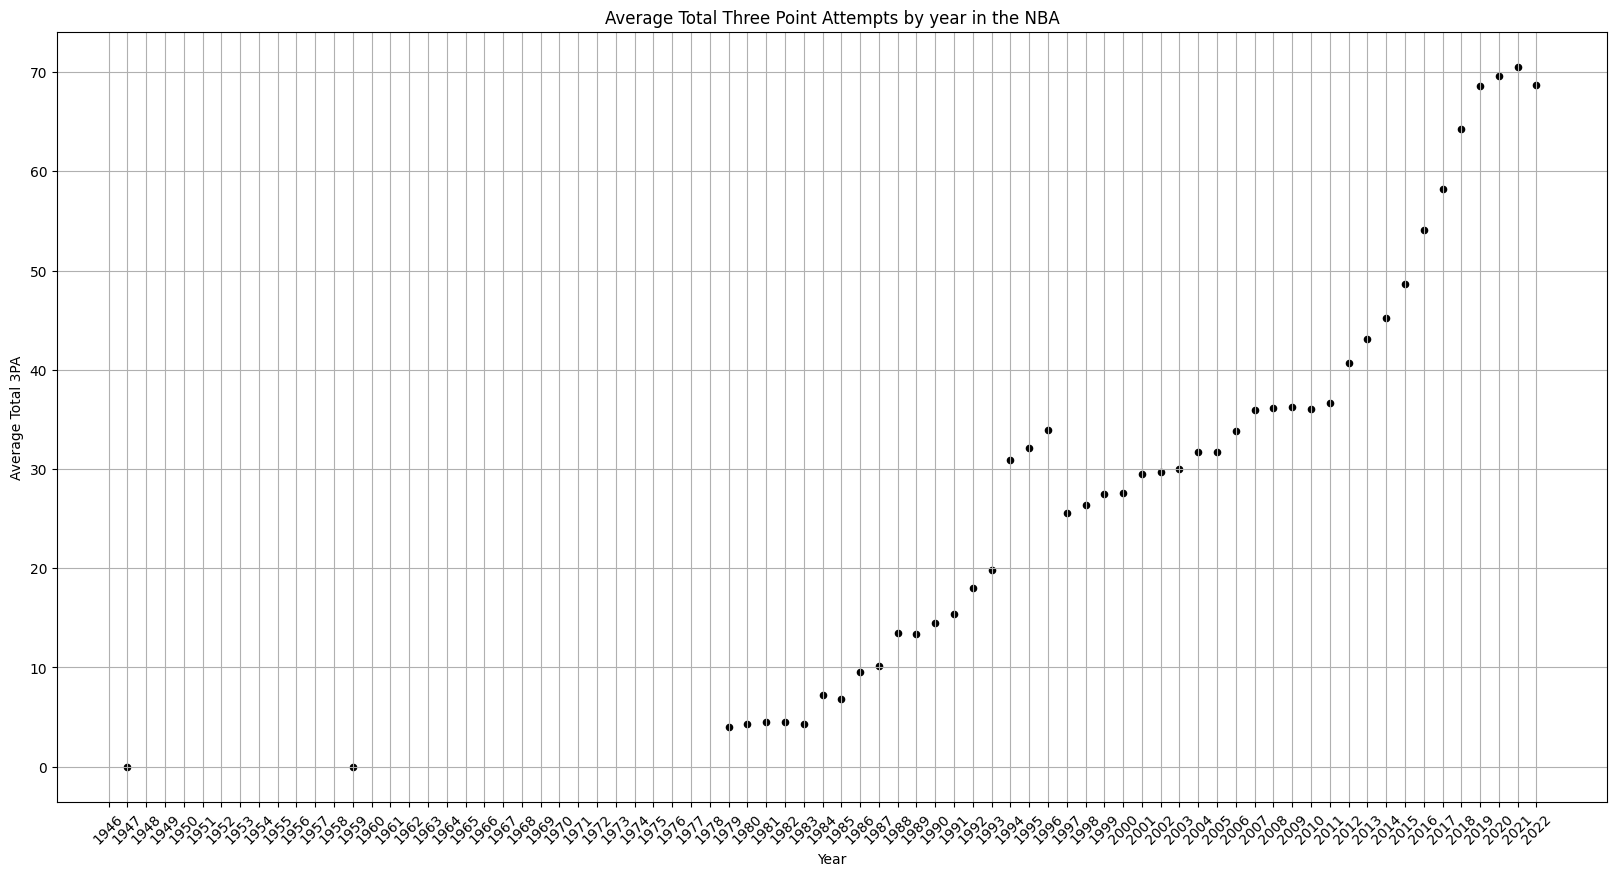

In [71]:
SeasonDF.plot.scatter(x='Year', y='Average Total 3PA', c='black', figsize = (20,10), rot = 45, title="Average Total Three Point Attempts by year in the NBA", grid=True)

# Trends in the Data

There are some interesting things to point out.

We can see that Points and Assists correlate with each other to a certain extent, which makes sense because Assists require Points to be scored. It should be noted that before around 1980 assist numbers seem almost random, and bear almost no correlation to points or anything else. 

At that same point, 1980, rebounds, steals and blocks basically level out. Rebounds sit at around 90, blocks sit at around 10, and steals start at 17.5 and drop a bit to settle at around 15. 

There is a bit of a negative correlation between 3PA and FTA which makes sense. As players take more 3 pointers they are making fewer shots right at the basket which have a higher foul likelihood. Though it's important to note free throw attempts decreased slowly while three pointers increased basically exponentially.

You can also see the 3 years in the mid 90s where the NBA shortened the 3 point line very clearly. 


# Next Step

Now we will look at some of the top players (ranked by salary acquired from NBA.com) and compare their draft stats to their current stats. For example, we will look at their weight, height and position now versus at their drafting. 